In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import functions as main
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Transform cluttered data

### Merge de todos os dados Macro num só CSV

In [31]:
from pathlib import Path
import glob

path = r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\variables_data"
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

dfs = []
for file in files:
    # Leitura do CSV
    data = pd.read_csv(file)
    
    # Ajuste do nome da coluna de datas para um nome consistente
    if 'DATE' in data.columns:
        data.rename(columns={'DATE': 'Date'}, inplace=True)
    
    if 'date' in data.columns:
        data.rename(columns={'date': 'Date'}, inplace=True)

    data["Date"] = pd.to_datetime(data.Date)

    # Definir a coluna de datas como índice
    data.set_index('Date', inplace=True)
    
    # Adicionar o DataFrame à lista
    dfs.append(data)

# Juntar todos os DataFrames usando o método "outer"
df = pd.concat(dfs, axis=1, join='outer')

In [32]:
df_daily = df.resample("D").last()

In [33]:
df_daily_mod = df_daily.loc["2010-09-10":]
df_daily_mod

,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,M2_Liquidity,EUR_USD,JPY_USD,JPY_EUR,SPY,QQQ,EXSA,...,IWDA,GLD,SLV,TLT,BND,Nr_Transactions,Nr_Addresses,BTC_PageViews,Crypto_PageViews,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-10,0.06180,7.128849e+02,5.942250e+02,NaN,1.269309,0.011915,0.00938,85.925018,41.027889,18.918182,...,19.975000,121.730003,19.420000,70.566566,55.395454,360.0,394.0,NaN,NaN,3.953550e+06
2010-09-11,0.06366,7.128849e+02,5.591766e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,305.0,330.0,NaN,NaN,3.961550e+06
2010-09-12,0.06150,7.128849e+02,9.393114e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,379.0,425.0,NaN,NaN,3.970400e+06
2010-09-13,0.06219,7.128849e+02,1.688811e+03,8682.7,1.271698,0.011861,0.00932,86.880722,41.600159,19.073298,...,20.040001,121.620003,19.540001,70.911400,55.537666,436.0,512.0,NaN,NaN,3.978950e+06
2010-09-14,0.06199,7.128849e+02,1.218628e+03,NaN,1.287200,0.011950,0.00928,86.826782,41.776257,19.045097,...,19.959999,124.019997,20.049999,71.594154,55.618946,424.0,459.0,NaN,NaN,3.989100e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,54031.82000,9.066650e+13,1.323774e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,548857.0,572484.0,7155.0,19.0,1.973616e+07
2024-08-06,56057.67000,9.066650e+13,6.808433e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,485173.0,502085.0,5944.0,28.0,1.973660e+07
2024-08-07,55130.45000,9.066650e+13,7.893852e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,380097.0,483579.0,5867.0,36.0,1.973698e+07


In [34]:
df_weekly_mod = df_daily_mod.resample('W-FRI').last() # close semanal à sexta feira

In [35]:
df_weekly_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 727 entries, 2010-09-10 to 2024-08-09
Freq: W-FRI
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_USD             727 non-null    float64
 1   Mining_Difficulty   727 non-null    float64
 2   USD_OnChain_Volume  725 non-null    float64
 3   M2_Liquidity        721 non-null    float64
 4   EUR_USD             726 non-null    float64
 5   JPY_USD             726 non-null    float64
 6   JPY_EUR             726 non-null    float64
 7   SPY                 726 non-null    float64
 8   QQQ                 726 non-null    float64
 9   EXSA                726 non-null    float64
 10  JPXN                726 non-null    float64
 11  IWDA                726 non-null    float64
 12  GLD                 726 non-null    float64
 13  SLV                 726 non-null    float64
 14  TLT                 726 non-null    float64
 15  BND                 726 no

In [36]:
df_weekly_mod.isna().sum()

BTC_USD                 0
Mining_Difficulty       0
USD_OnChain_Volume      2
M2_Liquidity            6
EUR_USD                 1
JPY_USD                 1
JPY_EUR                 1
SPY                     1
QQQ                     1
EXSA                    1
JPXN                    1
IWDA                    1
GLD                     1
SLV                     1
TLT                     1
BND                     1
Nr_Transactions         0
Nr_Addresses            0
BTC_PageViews         251
Crypto_PageViews      251
BTC_Supply              0
dtype: int64

In [37]:
df_weekly_mod.interpolate(method='linear', inplace=True)
df_weekly_mod = df_weekly_mod.loc[df_weekly_mod.index[1]:]

In [38]:
df_weekly_mod.isna().sum()

BTC_USD                 0
Mining_Difficulty       0
USD_OnChain_Volume      0
M2_Liquidity            0
EUR_USD                 0
JPY_USD                 0
JPY_EUR                 0
SPY                     0
QQQ                     0
EXSA                    0
JPXN                    0
IWDA                    0
GLD                     0
SLV                     0
TLT                     0
BND                     0
Nr_Transactions         0
Nr_Addresses            0
BTC_PageViews         250
Crypto_PageViews      250
BTC_Supply              0
dtype: int64

In [39]:
df_weekly_mod.to_csv(f"df_weekly.csv", date_format='%Y-%m-%d')

# OLS data Prep

In [12]:
opencsv = pd.read_csv(r"D:\OneDrive - Instituto Politecnico de Castelo Branco\002_Learning\001_Pos_Graduacao\Ciclo 5 - Projeto Final\ProjetoFinal-PosGraduacaoEngenhariaFinanceira\df_weekly.csv", sep=",")
opencsv.set_index('Date', inplace=True)
opencsv.index = pd.to_datetime(opencsv.index)
opencsv = opencsv.asfreq(pd.infer_freq(opencsv.index))
opencsv = opencsv.astype(float)

In [13]:

opencsv

,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,M2_Liquidity,EUR_USD,JPY_USD,JPY_EUR,SPY,QQQ,EXSA,...,IWDA,GLD,SLV,TLT,BND,Nr_Transactions,Nr_Addresses,BTC_PageViews,Crypto_PageViews,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,,,
2010-09-17,0.06010,7.128849e+02,4.175876e+03,8682.7,1.307600,0.011648,0.008900,87.167641,42.350613,18.805357,...,19.764999,124.540001,20.290001,70.118294,55.530895,361.0,375.0,NaN,NaN,4.018900e+06
2010-09-24,0.06220,9.178307e+02,1.059924e+03,8646.1,1.331913,0.011833,0.008880,88.973145,43.824387,18.875872,...,19.549999,126.690002,21.010000,71.380371,55.707008,501.0,572.0,NaN,NaN,4.091750e+06
2010-10-01,0.06197,1.318670e+03,2.111790e+03,8603.5,1.362212,0.011966,0.008780,88.810402,43.250763,18.551514,...,19.139999,128.910004,21.650000,72.414963,55.932384,584.0,672.0,NaN,NaN,4.157600e+06
2010-10-08,0.08685,1.318670e+03,8.206450e+03,8692.9,1.392796,0.012139,0.008710,90.305946,43.903801,18.791248,...,19.360001,131.660004,22.730000,72.144997,56.244728,363.0,454.0,NaN,NaN,4.206900e+06
2010-10-15,0.10500,1.378028e+03,4.345659e+03,8715.5,1.407202,0.012274,0.008720,91.204834,45.439342,19.016888,...,19.434999,133.679993,23.750000,69.410652,55.912010,328.0,403.0,NaN,NaN,4.267300e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,57913.68000,7.949520e+13,7.362339e+09,20947.5,1.087276,0.006321,0.005814,559.989990,494.820007,52.160000,...,96.339996,223.110001,28.120001,93.627892,72.757645,658355.0,486027.0,4441.0,29.0,1.972469e+07
2024-07-19,66708.49000,8.204773e+13,8.528315e+09,20947.5,1.090156,0.006363,0.005837,548.989990,475.239990,50.730000,...,94.370003,221.729996,26.690001,92.611282,72.498436,507940.0,510414.0,4161.0,27.0,1.972799e+07
2024-07-26,67925.17000,8.204773e+13,7.332171e+09,20947.5,1.085128,0.006506,0.005995,544.440002,462.970001,51.049999,...,93.745003,220.630005,25.480000,92.681046,72.717766,459067.0,529294.0,4953.0,48.0,1.973157e+07


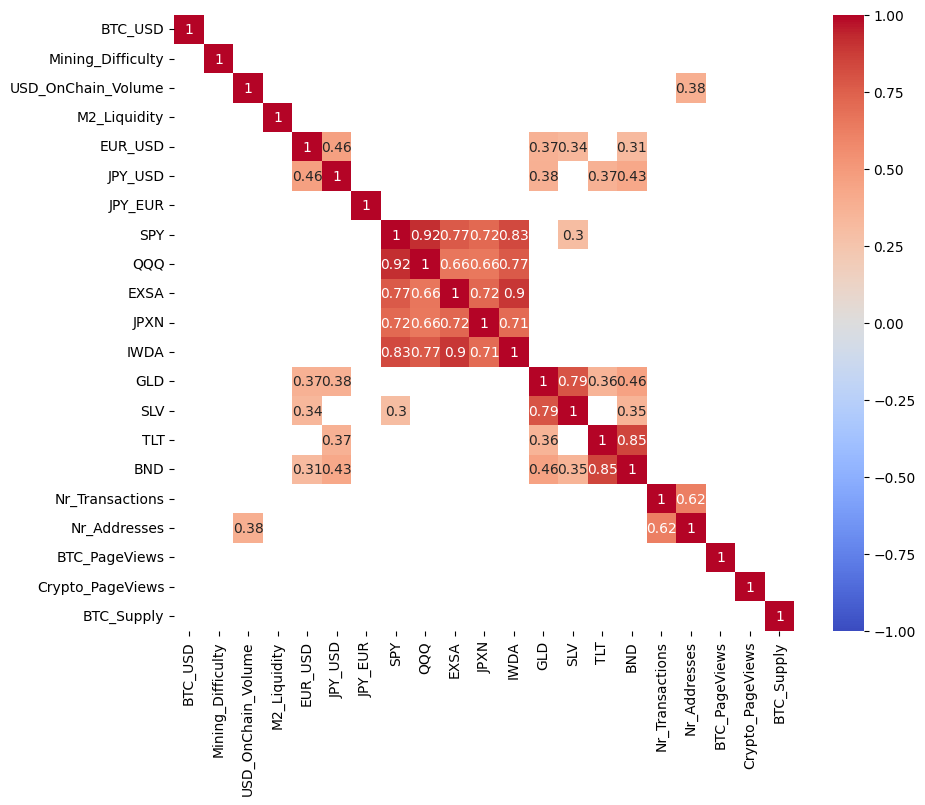

In [7]:
main.correlation_map(df=opencsv, threshold=0.3)

### Log Df

In [14]:
# transformacao logaritcmica de todas as colunas

#log_df = opencsv.copy()
log_df = opencsv.drop(columns=["BTC_PageViews", "Crypto_PageViews"])
log_df = np.log(log_df) 
log_df

,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,M2_Liquidity,EUR_USD,JPY_USD,JPY_EUR,SPY,QQQ,EXSA,JPXN,IWDA,GLD,SLV,TLT,BND,Nr_Transactions,Nr_Addresses,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,
2010-09-17,-2.811745,6.569320,8.337080,9.069088,0.268193,-4.452578,-4.721704,4.467833,3.745983,2.934142,3.493009,2.983913,4.824627,3.010128,4.250184,4.016940,5.888878,5.926926,15.206519
2010-09-24,-2.777400,6.822013,6.965952,9.064864,0.286616,-4.436870,-4.723954,4.488335,3.780190,2.937884,3.508930,2.972975,4.841743,3.044999,4.268023,4.020106,6.216606,6.349139,15.224483
2010-10-01,-2.781105,7.184379,7.655291,9.059924,0.309110,-4.425685,-4.735279,4.486504,3.767015,2.920551,3.508930,2.951780,4.859115,3.075005,4.282413,4.024144,6.369901,6.510258,15.240449
2010-10-08,-2.443573,7.184379,9.012676,9.070262,0.331314,-4.411343,-4.743284,4.503203,3.782001,2.933391,3.540258,2.963209,4.880223,3.123686,4.278678,4.029712,5.894403,6.118097,15.252237
2010-10-15,-2.253795,7.228409,8.376933,9.072858,0.341603,-4.400235,-4.742136,4.513108,3.816378,2.945327,3.536876,2.967076,4.895449,3.167583,4.240040,4.023779,5.793014,5.998937,15.266492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,10.966709,32.006718,22.719644,9.949775,0.083675,-5.063866,-5.147486,6.327919,6.204194,3.954316,4.325853,4.567884,5.407665,3.336481,4.539328,4.287134,13.397500,13.094019,16.797382
2024-07-19,11.108088,32.038322,22.866658,9.949775,0.086321,-5.057201,-5.143538,6.308080,6.163820,3.926517,4.311470,4.547223,5.401460,3.284289,4.528411,4.283565,13.138119,13.142977,16.797549
2024-07-26,11.126162,32.038322,22.715537,9.949775,0.081698,-5.034983,-5.116830,6.299758,6.137662,3.932806,4.294015,4.540578,5.396487,3.237894,4.529164,4.286586,13.036951,13.179299,16.797730


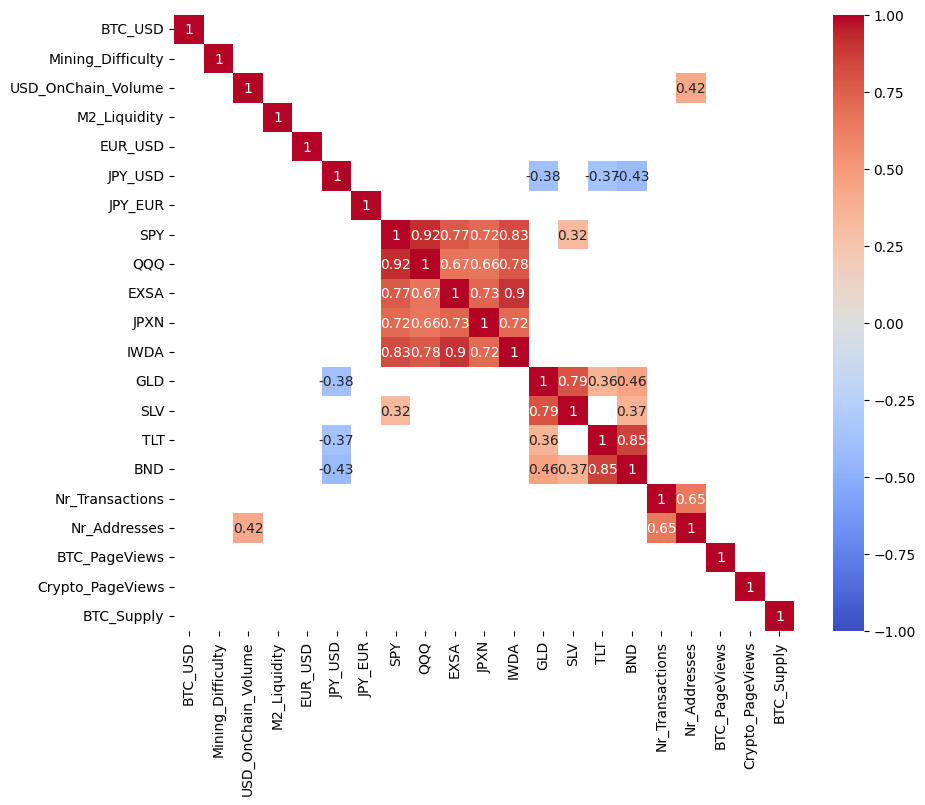

In [8]:
main.correlation_map(df=log_df, threshold=0.3)

In [17]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2010-09-17 to 2024-08-09
Freq: W-FRI
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_USD             726 non-null    float64
 1   Mining_Difficulty   726 non-null    float64
 2   USD_OnChain_Volume  726 non-null    float64
 3   M2_Liquidity        726 non-null    float64
 4   EUR_USD             726 non-null    float64
 5   JPY_USD             726 non-null    float64
 6   JPY_EUR             726 non-null    float64
 7   SPY                 726 non-null    float64
 8   QQQ                 726 non-null    float64
 9   EXSA                726 non-null    float64
 10  JPXN                726 non-null    float64
 11  IWDA                726 non-null    float64
 12  GLD                 726 non-null    float64
 13  SLV                 726 non-null    float64
 14  TLT                 726 non-null    float64
 15  BND                 726 no

In [16]:
log_df.isna().sum()

BTC_USD               0
Mining_Difficulty     0
USD_OnChain_Volume    0
M2_Liquidity          0
EUR_USD               0
JPY_USD               0
JPY_EUR               0
SPY                   0
QQQ                   0
EXSA                  0
JPXN                  0
IWDA                  0
GLD                   0
SLV                   0
TLT                   0
BND                   0
Nr_Transactions       0
Nr_Addresses          0
BTC_Supply            0
dtype: int64

### Winsorozation

In [20]:
from scipy.stats.mstats import winsorize

winsorized_df = log_df.apply(lambda col: winsorize(col, (0.01, 0.01)))
winsorized_df

,BTC_USD,Mining_Difficulty,USD_OnChain_Volume,M2_Liquidity,EUR_USD,JPY_USD,JPY_EUR,SPY,QQQ,EXSA,JPXN,IWDA,GLD,SLV,TLT,BND,Nr_Transactions,Nr_Addresses,BTC_Supply
Date,,,,,,,,,,,,,,,,,,,
2010-09-17,-1.589635,8.036488,8.337080,9.075505,0.268193,-4.452578,-4.721704,4.512395,3.829690,2.934142,3.493009,2.983913,4.824627,3.010128,4.250184,4.016940,6.135565,6.216606,15.317987
2010-09-24,-1.589635,8.036488,8.310720,9.075505,0.286616,-4.436870,-4.723954,4.512395,3.829690,2.937884,3.508930,2.972975,4.841743,3.044999,4.268023,4.020106,6.216606,6.349139,15.317987
2010-10-01,-1.589635,8.036488,8.310720,9.075505,0.309110,-4.425685,-4.735279,4.512395,3.829690,2.920551,3.508930,2.951780,4.859115,3.075005,4.282413,4.024144,6.369901,6.510258,15.317987
2010-10-08,-1.589635,8.036488,9.012676,9.075505,0.331314,-4.411343,-4.743284,4.512395,3.829690,2.933391,3.540258,2.963209,4.880223,3.123686,4.278678,4.029712,6.135565,6.216606,15.317987
2010-10-15,-1.589635,8.036488,8.376933,9.075505,0.341603,-4.400235,-4.742136,4.513108,3.829690,2.945327,3.536876,2.967076,4.895449,3.167583,4.240040,4.023779,6.135565,6.216606,15.317987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-12,10.966709,32.006718,22.719644,9.949775,0.083675,-5.055946,-5.133990,6.299354,6.155007,3.941163,4.305146,4.543614,5.396487,3.336481,4.539328,4.287134,13.343742,13.094019,16.796915
2024-07-19,11.108088,32.038322,22.866658,9.949775,0.086321,-5.055946,-5.133990,6.299354,6.155007,3.926517,4.305146,4.543614,5.396487,3.284289,4.528411,4.283565,13.138119,13.142977,16.796915
2024-07-26,11.119620,32.038322,22.715537,9.949775,0.081698,-5.034983,-5.116830,6.299354,6.137662,3.932806,4.294015,4.540578,5.396487,3.237894,4.529164,4.286586,13.036951,13.179299,16.796915


In [31]:
for column in winsorized_df.columns:
    if column != "BTC_USD":
        main.dispersion_map(df=winsorized_df, column1=winsorized_df["BTC_USD"], column2=winsorized_df[column])

# Split cycle Dfs

In [21]:
## ciclos
halving12 = "2012-11-28"
halving16 = "2016-07-09"
halving20 = "2020-05-11"
halving24 = "2024-04-19"

prep_df=opencsv.copy()

ciclo1 = prep_df.loc[:halving12]
ciclo2 = prep_df.loc[halving12:halving16]
ciclo3 = prep_df.loc[halving16:halving20]
ciclo4 = prep_df.loc[halving20:halving24]
ciclo5 = prep_df.loc[halving24:]

In [14]:
for i in range(1, 6):  # Loop from 1 to 5 to match your DataFrame names
    df = globals()[f'ciclo{i}']  # Access each DataFrame using its name
    df.to_csv(f"ciclo{i}_df.csv", date_format='%Y-%m-%d')  # Save each DataFrame with a dynamic filename